## Домашнее задание №2. Новопольский Артём

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import shapiro, bartlett, ttest_ind
from statsmodels.stats.power import TTestIndPower
warnings.filterwarnings('ignore')
sns.set(palette='bright')

### Описание кейса

1. На сайте проводится некоторый эксперимент. Время проведения эксперимента – *2 недели*. Всего на сайте **DAU** около *500 000* и **WAU** около *850 000*. Всего за время работы на сайте образовалась аудитория из около *1 500 000* не уходящих в отток посетителей.


2. В файле данные о результатах эксперимента. В колонке `group_id` вы видите bucket’ы с номерами *от 1 до 16*. К группе `A`, контрольной, относятся bucket’ы *1..8*, к группе `B`, экспериментальной – *9..16*. Колонки:
- `metric_value` – сумма целевых действий пользователей в рамках bucket’а – например, просмотров рекламного баннера, телефона на сайте classified-сервиса или покупок в retail/FMCG;
- `users` – кол-во пользователей, совершивших целевое действие, 
- `visits` – кол-во целевых сессий,
- `churn_users` и `churn_visits` – кол-во пользователей в рамках bucket’а, отказавшихся сделать заказ, и сессий, не закончившихся успешным целевым действием.

3. Менеджера продукта интересует, какие **позитивные** и **негативные** эффекты вызвало нововведение. Продумайте **метрики**, которые стоит исследовать в рамках имеющихся данных для ответа на вопрос менеджера.


### Описание задания

1. Загрузите данные из файла в структуру `pandas.DataFrame()`.

2. Проведите *оценку равенства дисперсий* исследуемых метрик в группах и исследуйте *распределение на нормальность*. Какими критериями вы воспользовались и почему?

3. Оцените *статистическую значимость различий* исследуемых метрик в выборках. Какой критерий вы выбрали для оценки и почему?

4. Размер генеральной совокупности составляет *1 500 000*. Достаточен ли *размер выборок* для представления достоверных выводов? Если нет, сколько ещё по времени следует проводить тест и/или на какую долю пользователей его раскатывать, чтобы результаты можно было считать достоверными?

5. Изобразите *гистограммы* и *диаграммы размаха*.

6. Результат работы пришлите в формате *IPython Jupyter Notebook* на сервисе *Google Colab*.

## Импорт данных

In [2]:
user_data = pd.read_csv('../data/hw_ab_test.csv', sep='\t', index_col=0)
user_data.head()

,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,8,6630.000,0,0,0,8,A
1,13,6933.976,0,0,1,6,B
2,10,8261.976,1,10,1,8,B
3,4,5522.000,1,9,1,7,A
4,16,5075.976,1,6,0,8,B


Убедимся, что в нашем наборе данных отсутствуют пропущенные значения:

In [3]:
user_data.isna().values.sum() == 0

True

Посмотрим, сколько пользователей содержится в контрольной и тестовой группах, чтобы удостовериться, что количество наблюдений сбалансировано:

In [4]:
print('Control group size:', len(user_data.loc[user_data.group == 'A']), 
      '\nTest group size:', len(user_data.loc[user_data.group == 'B']))

Control group size: 2451 
Test group size: 2549


Для более удобного анализа сгруппируем пользователей по бакетам (поле `group_id`) и посмотрим на кумулятивные показатели:

In [5]:
bucket_data = user_data.groupby('group_id', as_index=False).sum()
bucket_data

,group_id,metric_value,users,visits,churn_users,churn_visits
0,1,1875345.000,155,1419,151,2207
1,2,1662237.000,138,1320,127,1853
2,3,1784372.000,128,1281,159,2032
3,4,1876826.000,163,1644,168,2172
4,5,1913180.000,156,1675,174,2273
5,6,1733079.000,144,1509,141,2009
6,7,1864555.000,151,1481,161,2139
7,8,2029143.000,162,1533,153,2299
8,9,2047289.536,143,1424,242,2191
9,10,2228154.648,179,1803,265,2518


Из полученных данных видно, что значение целевой метрики (`metric_value`) в бакетах 1-8 (контрольная группа) как правило меньше, чем в бакетах 9-16 (тестовая группа). 
Также видно, что количество пользователей, отказавшихся сделать заказ (`churn_users`) в тестовой группе больше, чем в контрольной. 
Различия в остальных метриках выглядят статистически не значимыми.

## Графический анализ данных

Начнём проверку выдвинутых предположений с **визуализации данных**. Для этого разобьём сгруппированные данные по бакетам: бакеты *1..8* отнесём к контрольной группе, бакеты *9..16* - к тестовой.

In [6]:
control = bucket_data.loc[bucket_data['group_id'].isin(range(1, 9))]
test = bucket_data.loc[bucket_data['group_id'].isin(range(9, 17))]

Для визуализации создадим функцию - `show_plots`, которая будет принимать на вход данные для контрольной и тестовой групп, а также метрики, которые нужно визуализировать.

Функция будет отображать два графика для каждой метрики - **гистограмму** метрики в контрольной и тестовой группах с гладкой оценкой распределения, а также **диаграмму размаха** (box-plot) метрики в контрольной и тестовой группах.

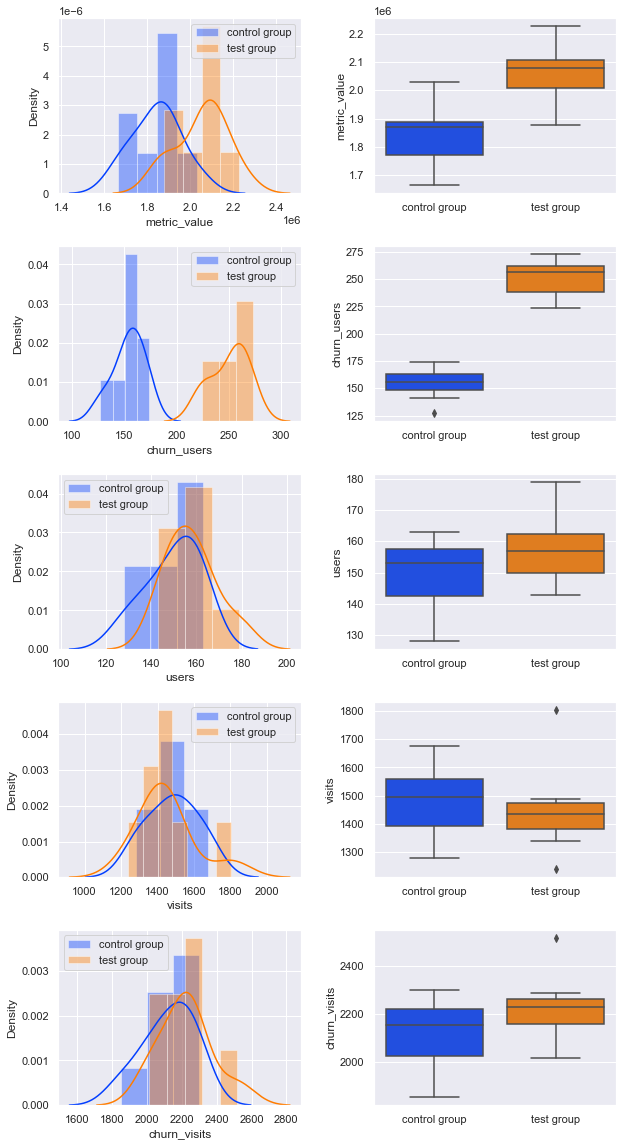

In [7]:
def show_plots(control, test, metrics):
    fig, axes = plt.subplots(len(metrics), 2, figsize=(10, 20))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for i, metric in enumerate(metrics):
        sns.distplot(control[metric], ax=axes[i, 0], label='control group')
        sns.distplot(test[metric], ax=axes[i, 0], label='test group')
        axes[i, 0].legend()
        
        sns.boxplot(data=[control[metric], test[metric]], ax=axes[i, 1]).set(
            xticklabels=['control group', 'test group'], 
            ylabel=metric,
        )
    plt.show()

metrics = ['metric_value', 'churn_users', 'users', 'visits', 'churn_visits']
show_plots(control, test, metrics)

### Интерпретация графиков

Обсудим метрики в порядке их визуализации и начнём с целевой метрики **`metric_value`** в тестовой и контрольных группах. 

На гистограмме видим, что данные в тестовой группе смещены относительно контрольной. А *box-plot* позволяет нам всерьёз задуматься о значимом различии между группами, так как медиана каждой выборки не входит в диапазон "усов" другой выборки.

Перейдем к графическому анализу метрики **`churn_users`**: по полученным графикам отчётливо видно, что между группами есть различия, значимость которых нужно будет изучить детальнее. 

Перейдём к метрике **`users`**: по графикам можно заключить, что в ходе эксперимента метрика **`users`** (кол-во пользователей, совершивших целевое действие) осталась на том же уровне и исследовать её более глубоко не имеет смысла.

Посмотрим на метрику кол-ва целевых сессий **`visits`**: по графикам заметно, что эксперимент не оказал воздействия на метрику **`visits`**, так как значения контрольной и тестовой групп почти не смещены относительно друг друга. 

Перейдём к заключительной метрике в исходных данных - **`churn visits`** (сессии, не закончившиеся успешным целевым действием): на графиках видно, что значения метрики **`churn_visits`** в тестовой и контрольной группах остаются примерно на одном уровне и в дальнейшем исследовании различий нет смысла.

### Вывод по графикам
С помощью гистограмм и "ящиков с усами" мы подтвердили выдвинутое предположение о том, что эксперимент оказал серьёзное воздействие на метрики `metric_value` и `churn_users`, поэтому в дальнейшем анализе сосредоточимся на исследовании значимости их различий в тестовой и контрольной группах.

По графикам также заметно, что распределения исследуемых метрик имеют распределение, близкое к нормальному. Проверим это ниже.

## Проверка данных на нормальность

Подкрепим наши предположения о различиях метрик `metric_value` и `churn_users` в контрольной и тестовой группах с помощью статистических тестов. Для начала необходимо проверить данные из групп на нормальность с помощью **критерия Шапиро-Уилка**. Его нулевая гипотеза заключается в том, что выборка имеет нормальное распределение.

Данный критерий был выбран из-за того, что обладает большей мощностью (способностью не допустить ошибку 2-го рода, то есть ложно принять нулевую гипотезу), чем, например, непараметрические критерии Колмогорова-Смирнова и Андерсена-Дарлинга.

In [8]:
def calc_shapiro_wilk_test(control, test):
    control_res = shapiro(control)
    test_res = shapiro(test)
    return control_res, test_res

alpha = 0.05
metric_value_res = calc_shapiro_wilk_test(control['metric_value'], test['metric_value'])
churn_users_res = calc_shapiro_wilk_test(control['churn_users'], test['churn_users'])

print('Распределение metric_value в контрольной группе:',
      ('нормальное. H0 принята.' if metric_value_res[0][1] > alpha else 'отличное от нормального. H0 отвергнута.'), 
      '\nРаспределение metric_value в тестовой группе:',
      ('нормальное. H0 принята.' if metric_value_res[1][1] > alpha else 'отличное от нормального. H0 отвергнута.'))

print('Распределение churn_users в контрольной группе:',
      ('нормальное. H0 принята.' if churn_users_res[0][1] > alpha else 'отличное от нормального. H0 отвергнута.'), 
      '\nРаспределение churn_users в тестовой группе:',
      ('нормальное. H0 принята.' if churn_users_res[1][1] > alpha else 'отличное от нормального. H0 отвергнута.'))

Распределение metric_value в контрольной группе: нормальное. H0 принята. 
Распределение metric_value в тестовой группе: нормальное. H0 принята.
Распределение churn_users в контрольной группе: нормальное. H0 принята. 
Распределение churn_users в тестовой группе: нормальное. H0 принята.


Можем утверждать, что метрики `metric_value` и `churn_users` в каждой группе имеют нормальное распределение

## Оценка равенства дисперсий

Теперь можем проверить, равны ли дисперсии у групп с помощью **критерия Бартлетта**. Данный критерий был выбран из-за своей универсальности (может оценивать равенство дисперсий 2-х и более выборок), а также из-за того, что обладает большей мощностью, чем, например, критерий Левена.

Нулевая гипотеза критерия предполагает, что рассматриваемые выборки получены из генеральных совокупностей, обладающих одинаковыми дисперсиями.

In [9]:
alpha = 0.05
metric_value_res = bartlett(control['metric_value'], test['metric_value'])
churn_users_res = bartlett(control['churn_users'], test['churn_users'])

print('Дисперсии metric_value у контрольной и тестовой групп:',
      ('равны. H0 принята.' if metric_value_res[1] > alpha else 'не равны. H0 отвергнута.'))

print('Дисперсии churn_users у контрольной и тестовой групп:',
      ('равны. H0 принята.' if churn_users_res[1] > alpha else 'не равны. H0 отвергнута.'))

Дисперсии metric_value у контрольной и тестовой групп: равны. H0 принята.
Дисперсии churn_users у контрольной и тестовой групп: равны. H0 принята.


С помощью теста Бартлетта мы убедились, что дисперсии в группах равны. Можем перейти к самой важной части исследования - оценки статистической значимости различий.

## Оценка статистической значимости различий 

Наконец, можем перейти к статистической оценке значимости различий метрик `metric_value` и `churn_visits` в контрольной и тестовых группах. Так как наши бакеты независимы,  распределения близки к нормальному и дисперсии в группах равны, то для этого мы будем использовать **t-критерий Стьюдента для независимых выборок**. 

Нулевая гипотеза t-теста предполагает, что средние в двух выборках равны.

In [10]:
alpha = 0.05
metric_value_res = ttest_ind(control['metric_value'], test['metric_value'])
churn_users_res = ttest_ind(control['churn_users'], test['churn_users'])

print('Средние значения metric_value у контрольной и тестовой групп:',
      ('равны. H0 принята.' if metric_value_res[1] > alpha else 'не равны. H0 отвергнута.'))

print('Средние значения churn_users у контрольной и тестовой групп:',
      ('равны. H0 принята.' if churn_users_res[1] > alpha else 'не равны. H0 отвергнута.'))

Средние значения metric_value у контрольной и тестовой групп: не равны. H0 отвергнута.
Средние значения churn_users у контрольной и тестовой групп: не равны. H0 отвергнута.


Результаты теста Стьюдента позволяют нам заявить о том, что эксперимент значимо повлиял на метрики `metric_value` и `churn_users`. Но достаточен ли объём наших данных, чтобы делать такие выводы? Узнаем ниже.

## Расчёт необходимого объёма выборки

Удостоверимся, что объём выборок, которые мы анализировали, достаточен для представления достоверных выводов о различии средних. Уровень мощности  $(1-\beta)$ стандартно равняется 0.8, уровень значимости $\alpha$ = 0.05. 

В качестве значения эффекта возьмём полученный относительный прирост среднего значения метрики после эксперимента:

$$effect=\frac{test_{mean}-control_{mean}}{control_{mean}}$$

In [11]:
def calc_sample_size(control, test):
    alpha = 0.05
    power = 0.8
    effect = (test.mean() - control.mean()) / control.mean()
    result = TTestIndPower().solve_power(effect_size=effect, power=power, alpha=alpha, nobs1=None, ratio=1.0)
    return result

metric_value_res = calc_sample_size(control['metric_value'], test['metric_value'])
churn_users_res = calc_sample_size(control['churn_users'], test['churn_users'])
print(f'Необходимый объём выборки для metric_value: {round(metric_value_res, 3)}')
print(f'Необходимый объём выборки для churn_users: {round(churn_users_res, 3)}')

Необходимый объём выборки для metric_value: 1191.269
Необходимый объём выборки для churn_users: 41.299


Получаем следующие цифры: при полученном эффекте по метрике `metric_value` для достоверных выводов нужно *1191* наблюдение, по метрике `churn_users` - *41*. Стоит напомнить, что анализ мы проводили на кумулятивных данных по бакетам. Суммарный объём наблюдений в бакетах, относящихся к контрольной группе A, составляет *2451* наблюдение (это было рассчитано в самом начале), к тестовой группе B - *2549*. 

Таким образом, размер анализируемых выборок достаточен, чтобы достоверно заключить о том, что метрики `metric_value` и `churn_users` значимо различаются в контрольной и тестовой группе.

## Заключение

Осталось ответить на самый главный вопрос - **какие позитивные и негативные эффекты вызвало нововведение**.

Стоит начать с того, что значение целевой метрики `metric_value`, на которую был нацелен эксперимент, значимо увеличилось, что является *позитивным эффектом* проведенного A/B-теста.

Однако у полученного результата есть и обратная сторона, которая заключается в том, что при росте целевой метрики мы получили значимое увеличение кол-ва пользователей, ушедших в отток (`churn_users`).

В долгосрочной перспективе это окажет негативное влияние на сервис - из-за нелояльных пользователей будет снижаться репутация сервиса, а также метрики *DAU* и *WAU*, что отрицательно отразится на финансовых показателях.

Возможно, новое решение "агрессивно" что-то навязывает. Поэтому необходимо понять, чем новые фичи могли не устроить пользователей. Следует скорректировать текущее решение так, чтобы сбалансировать выгоду сервиса и лояльность пользователей. И в идеале провести тест ещё раз.

В текущем виде катить не стоит, так как различия в `churn_users` выражены гораздо сильнее, чем прирост `metric_value` (это можно понять, исходя из построенных графиков и рассчитанных объёмов выборок, необходимых для получения статистически значимых результатов). Значимо терять пользователей из-за роста метрики не стоит.